Insper

## Supercomputação - Dask

## 1. Setup inicial e obtendo os dados

In [1]:
!pip install dask[complete]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install graphviz

In [3]:
import pandas as pd
import numpy as np
from dask import delayed
from time import sleep

In [4]:
!wget https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz
!mkdir data
!tar -xvzf nycflights.tar.gz -C data

--2024-10-18 17:03:26--  https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 142.250.98.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44120091 (42M) [application/x-gzip]
Saving to: ‘nycflights.tar.gz’

nycflights.tar.gz   100%[===================>]  42.08M  67.5MB/s    in 0.6s    

2024-10-18 17:03:27 (67.5 MB/s) - ‘nycflights.tar.gz’ saved [44120091/44120091]

nycflights/
nycflights/1990.csv
nycflights/1991.csv
nycflights/1992.csv
nycflights/1993.csv
nycflights/1994.csv
nycflights/1995.csv
nycflights/1996.csv
nycflights/1997.csv
nycflights/1998.csv
nycflights/1999.csv


In [5]:
import glob

filenames = glob.glob("data/nycflights/*.csv")

for i in filenames:
  print(i)

data/nycflights/1996.csv
data/nycflights/1999.csv
data/nycflights/1995.csv
data/nycflights/1997.csv
data/nycflights/1990.csv
data/nycflights/1992.csv
data/nycflights/1998.csv
data/nycflights/1994.csv
data/nycflights/1991.csv
data/nycflights/1993.csv


## 1.1 Usando Pandas para obter o maior atraso dentre todos os voos

In [6]:
# Qual é o maior atraso (DepDelay) dentre todos os voos (todos os arquivos)?
%%time
lista = []

for f in filenames:
  df = pd.read_csv(f)
  max_ = df["DepDelay"].max()
  lista.append(max_)

final_max = max(lista)
print(final_max)

1435.0
CPU times: user 6.64 s, sys: 351 ms, total: 6.99 s
Wall time: 7.06 s


## 2. Usando Dask Delayed para obter o maior atraso dentre todos os voos

In [8]:
# Qual é o maior atraso (DepDelay) dentre todos os voos (todos os arquivos)?
%%time
lista = []

for f in filenames:
  df = delayed(pd.read_csv)(f)
  max_ = df["DepDelay"].max()
  lista.append(max_)

final_max = delayed(max)(lista)
print(final_max)

Delayed('max-55add871-01ed-4dcd-be51-b6db980978ab')
CPU times: user 6.5 ms, sys: 955 µs, total: 7.45 ms
Wall time: 10.1 ms


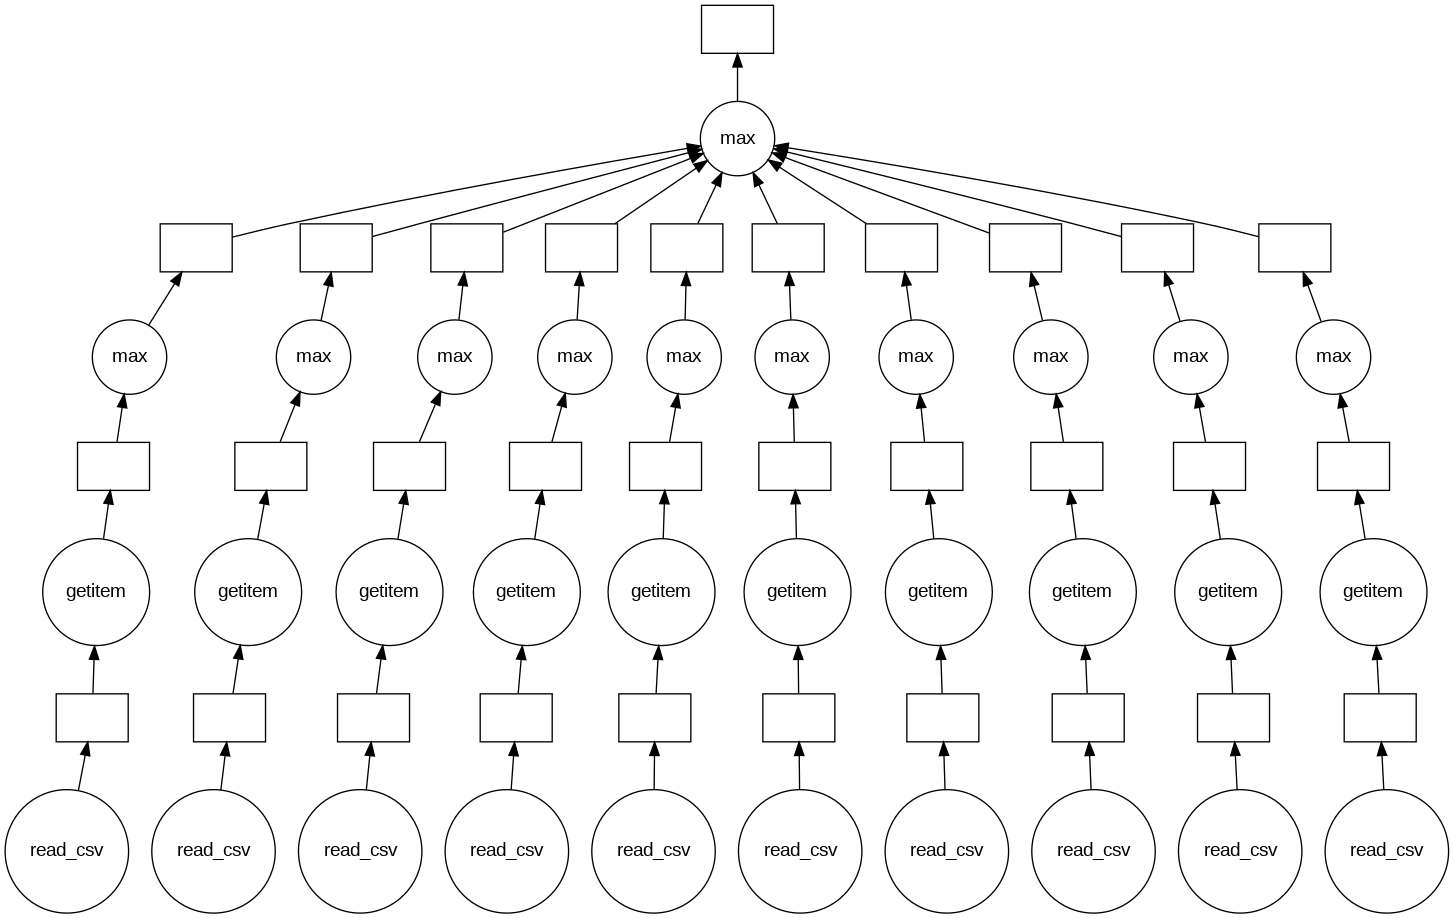

In [9]:
final_max.visualize()

In [10]:
%%time
final_max.compute()

CPU times: user 10.7 s, sys: 1.24 s, total: 11.9 s
Wall time: 7.33 s


1435.0

## 3. Usando Dask DataFrames

In [11]:
import dask.dataframe as ddf

In [12]:
%%time
dados = ddf.read_csv("data/nycflights/*.csv")
dados["DepDelay"].max().compute()

CPU times: user 3.52 s, sys: 115 ms, total: 3.63 s
Wall time: 1.96 s


1435.0

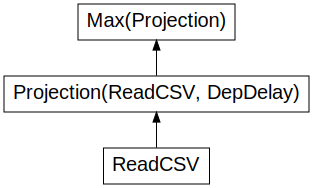

In [13]:
# Grafo do maior atraso?
dados["DepDelay"].max().visualize()

In [14]:
# Maior atraso por origem?
dados.groupby("Origin").DepDelay.max().compute()

,DepDelay
Origin,
EWR,1134.0
JFK,1435.0
LGA,1435.0


Obter os voos não cancelados

Obter a média e o desvio padrão dos atrasos dos voos não cancelados

In [15]:
df = ddf.read_csv("data/nycflights/*.csv")

In [16]:
# Primeiras linhas
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [17]:
# Últimas linhas
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.


Ao contrário do pandas.read_csv, que lê o arquivo inteiro antes de inferir os tipos de dados, dask.dataframe.read_csv lê apenas uma amostra do início do arquivo (ou do primeiro arquivo, se estiver usando um glob). Esses tipos de dados inferidos são então aplicados ao ler todas as partições.

In [18]:
df = ddf.read_csv("data/nycflights/*.csv",
                  dtype = {"TailNum": str,
                           "CRSElapsedTime": float,
                           "Cancelled": bool})

In [19]:
non_cancelled = df[~df["Cancelled"]]

In [20]:
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()

In [21]:
%%time
mean_delay_result = mean_delay.compute()
print(mean_delay_result)

9.206602541321965
CPU times: user 4.08 s, sys: 236 ms, total: 4.32 s
Wall time: 2.37 s


In [22]:
%%time
std_delay_result = std_delay.compute()
print(std_delay_result)

28.974539774551456
CPU times: user 3.95 s, sys: 212 ms, total: 4.16 s
Wall time: 2.34 s


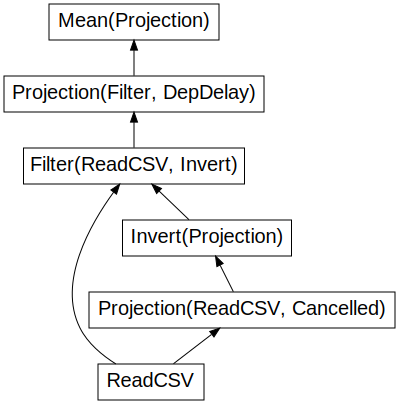

In [23]:
mean_delay.visualize()

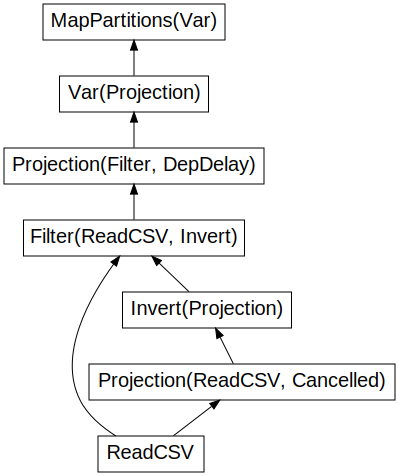

In [24]:
std_delay.visualize()

In [25]:
import dask

In [26]:
mean_delay_result, std_delay_result = dask.compute(mean_delay, std_delay)

## 4. Reescrevendo nosso primeiro exemplo com _futures_

Uso comum:

```python
def process_file(filename):
    data = read_a_file(filename)
    data = do_a_transformation(data)
    destination = f"results/{filename}"
    write_out_data(data, destination)
    return destination

futures = []
for filename in filenames:
    future = client.submit(process_file, filename)
    futures.append(future)

futures

```

In [27]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def double(x):
    sleep(2)
    return 2 * x

def add(x, y):
    sleep(1)
    return x + y

In [28]:
# Iniciando um cluster dask com 4 executores
from dask.distributed import Client

client = Client(n_workers=4)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37115
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37187'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36537'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43661'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38513'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44481', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44481
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42192
INFO:distributed.scheduler:Regist

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37115,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:32975,Total threads: 1
Dashboard: http://127.0.0.1:42491/status,Memory: 3.17 GiB
Nanny: tcp://127.0.0.1:37187,


Rodando localmente

In [29]:
double(9)

18

Ou podemos enviá-los para execução remota com Dask. Isso retorna imediatamente um futuro que aponta para a computação em andamento e, eventualmente, para o resultado armazenado.

In [30]:
future = client.submit(double, 9)
future

<Future: pending, key: double-a6be9e5e4acfbdc22c89d9486a3e74d6>

In [31]:
# Após algum tempo, estará executado!
future

<Future: finished, type: int, key: double-a6be9e5e4acfbdc22c89d9486a3e74d6>

In [32]:
# E qual é o resultado?
future.result()

18

**Por que usar Futures?**

A API de futuros oferece um estilo de envio de trabalho que pode facilmente emular o paradigma mapear/reduzir. Se isso lhe é familiar, então os futuros podem ser o ponto de entrada mais simples no Dask.

O outro grande benefício dos futuros é que os resultados intermediários, representados pelos futuros, podem ser passados para novas tarefas sem a necessidade de extrair dados localmente do cluster. Novas operações podem ser configuradas para trabalhar na produção de trabalhos anteriores que ainda nem começaram.

## 5. [Exercícios] Cálculos em cima de Dask DataFrames

Continue utilizando os arquivos "data/nycflights/*.csv". Resolva as seguintes questões:

  a. Qual é o atraso Médio na Chegada por Transportadora

  b. Top 5 Rotas mais Curtas: rotas com a menor distância média

  c. Dias da Semana com Mais Voos

  d. Identificar Voos com Maior Atraso de Chegada

  e. Análise de Correlação entre Atraso na Partida e Chegada


In [45]:
# a)
arr_delay_mean = df.groupby("UniqueCarrier").ArrDelay.mean()
arr_delay_mean.compute()

,ArrDelay
UniqueCarrier,
AA,5.963033
CO,9.762624
DL,7.961324
EA,5.435499
HP,14.221614
NW,6.216828
PA (1),-0.814996
TW,9.378095
UA,6.562766


In [41]:
# b)
shortest_routes = df.groupby(["Origin", "Dest"]).Distance.mean()
shortest_routes.compute().sort_values()[:5]

,,Distance
Origin,Dest,
JFK,LGA,11.0
LGA,JFK,11.0
EWR,LGA,17.0
LGA,EWR,17.0
EWR,JFK,21.0


In [44]:
# c)
days_of_week = df.groupby("DayOfWeek").FlightNum.count()
days_of_week.compute().sort_values(ascending=False)

,FlightNum
DayOfWeek,
2,388912
3,388042
1,388011
4,386116
5,385544
7,354688
6,320579


In [52]:
# d)
arr_delay = df.ArrDelay
arr_delay.compute().sort_values(ascending=False)[:20]

,ArrDelay
113197,1156.0
26396,1090.0
231322,1064.0
160175,1057.0
93017,1037.0
122146,1031.0
132025,1024.0
167181,1021.0
164023,993.0
120176,991.0


In [53]:
# e)
df["ArrDelay"].corr(df["DepDelay"]).compute()

0.8304247583395481